In [1]:
# SecureString parameter stored in AWS System Manager that holds a GitHub personal access token.
parameter_name = 'github_token'

# Repositories for which reports will be generated.
repo_names = ['aws-amplify/amplify-android', 'aws-amplify/aws-sdk-android', 'awslabs/aws-mobile-appsync-sdk-android']

# Labels used across different repositories
issue_buckets = {'Bug': ['Bug'],
                 'Feature Request': ['Improvement', 'Feature Request'],
                 'Question': ['Usage Question'],
                 'Pending Triage': ['Pending Triage']}

In [2]:
# Retrieve the GitHub token from SSM to prevent oops-I-pushed-credentials-to-GitHub uh-ohs.

import boto3

ssm = boto3.client('ssm')
response = ssm.get_parameter(Name=parameter_name, WithDecryption=True)
token = response['Parameter']['Value']

In [3]:
# Grab all issues from the GitHub V4 GraphQL API

import requests
import json

headers = {'Authorization': f'Bearer {token}'}

def get_issues(owner, name, *, end_cursor=None):
    query = """
    query($owner: String!, $name: String!, $endCursor: String) {
      repository(owner:$owner, name:$name) {
        issues(first:100, after:$endCursor) {
          nodes {
            number
            title
            createdAt
            closedAt
            reactions {
              totalCount
            }
            comments(first:100) {
              nodes {
                createdAt
                author {
                  login
                }
                reactions {
                  totalCount
                }
              }
            }
            labels(first:3) {
              nodes {
                name
              }
            }
          }
          pageInfo {
            hasNextPage
            endCursor
          }
        }
      }
    }"""
    
    variables = {'owner': owner, 'name': name, 'endCursor': end_cursor}
    response = execute(query, variables)
    page_info = response['data']['repository']['issues']['pageInfo']
    nodes = response['data']['repository']['issues']['nodes']
    
    for issue in nodes:
        yield issue
    
    if page_info['hasNextPage']:
        yield from get_issues(owner, name, end_cursor=page_info['endCursor'])
    
def execute(query, variables):
    request = requests.post('https://api.github.com/graphql', json={'query': query, 'variables': variables},
                                                              headers=headers)

    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("{}: {}".format(request.status_code, query))

In [4]:
# Loop through each repository, grab all issues, and create a DataFrame for each.

import pandas as pd

repos = {}
bucket_lookup = {label: bucket for bucket, labels in issue_buckets.items() for label in labels}

for repo_name in repo_names:
    issues = []
    owner, name = repo_name.split('/')

    for issue in get_issues(owner, name):
        labels = pd.array([label['name'] for label in issue['labels']['nodes']])
        bucket = 'Other'
        created_at = pd.Timestamp(issue['createdAt'],tz='UTC')
        
        score = 1
        score += len(issue['comments']) 
        score += issue['reactions']['totalCount']
        score += sum(comment['reactions']['totalCount'] for comment in issue['comments']['nodes'])
        
        if issue['closedAt']:
            closed_at = pd.Timestamp(issue['closedAt'], tz='UTC')
        else:
            closed_at = None
            
        for label in labels:
            if label in bucket_lookup:
                bucket = label
                break
                
        issues.append([issue['number'], issue['title'], labels, created_at, closed_at, bucket, score])
        
    repos[repo_name] = pd.DataFrame(issues, columns=['id', 'title', 'labels', 'created_at', 'closed_at', 'bucket', 'score'])

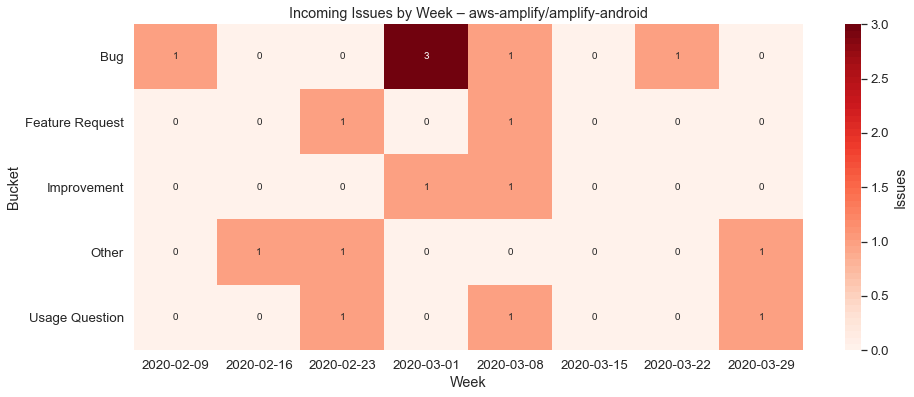

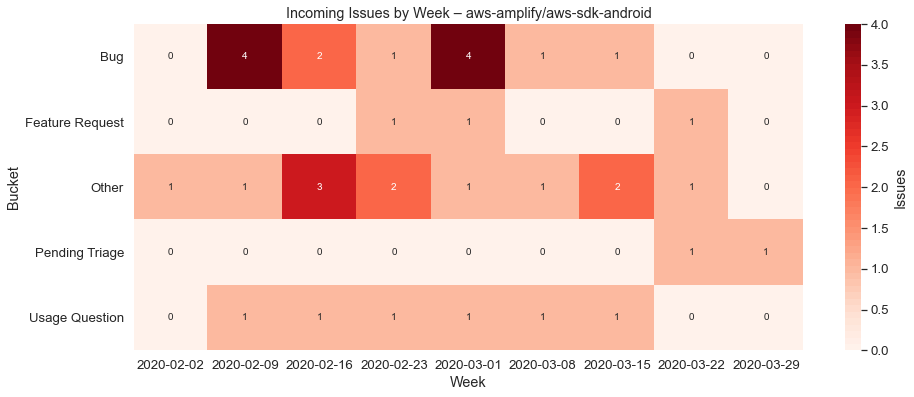

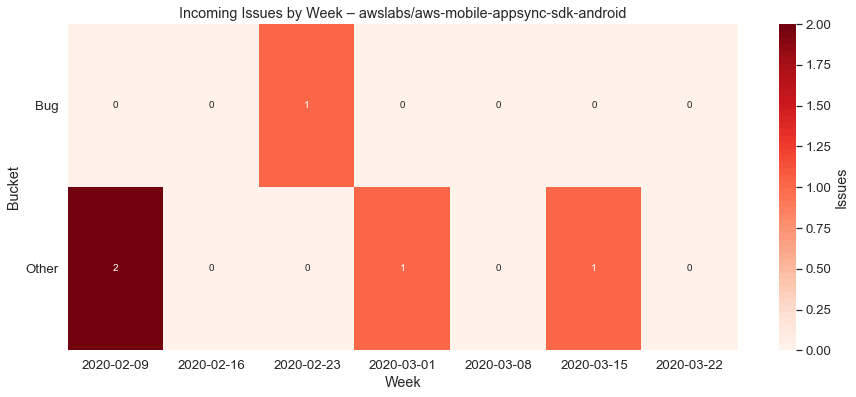

In [5]:
from IPython.core.display import HTML
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)
idx = pd.date_range(now - timedelta(weeks=4), now, freq='W')   

sns.set(font_scale=1.2)

%matplotlib inline

for repo_name, df in repos.items():
    plt.subplots(figsize=(15, 6))
    
    df = df.loc[df.created_at > now - timedelta(weeks=8)] 
    df = df.pivot(index='created_at', columns='bucket', values='created_at')
    df = pd.concat([df, pd.DataFrame(index=[date for date in idx])])    
    df = df.resample('W', label='left').count().transpose()
    dates = df.columns.strftime('%Y-%m-%d').sort_values().unique()

    ax = sns.heatmap(df, xticklabels=dates, cmap=sns.color_palette("Reds", 50), fmt='d', annot=True,
                     cbar_kws={'label': 'Issues'})
    ax.set(xlabel='Week', ylabel='Bucket', title=f'Incoming Issues by Week – {repo_name}')

    plt.yticks(rotation=0)
    plt.show()

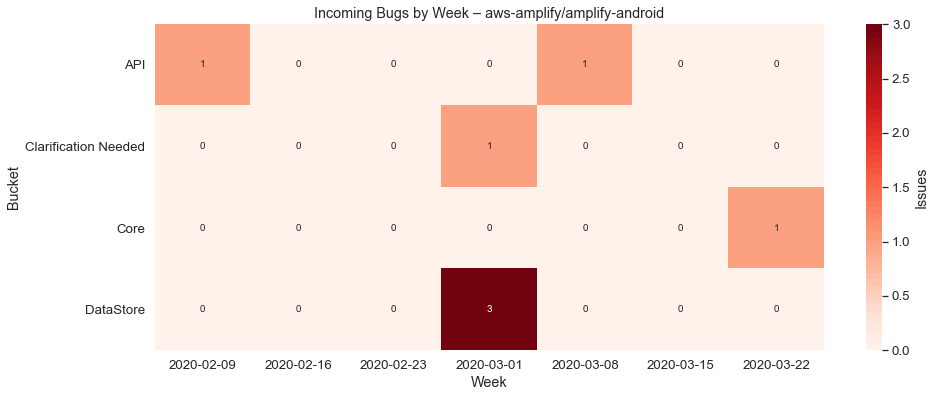

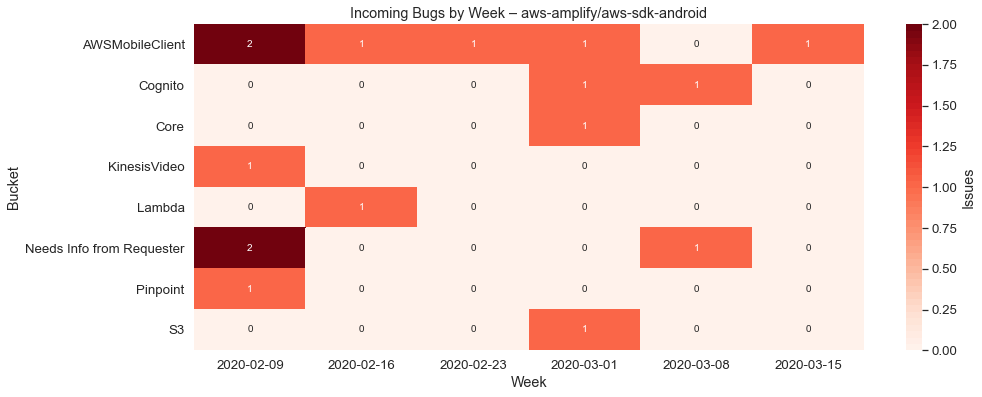

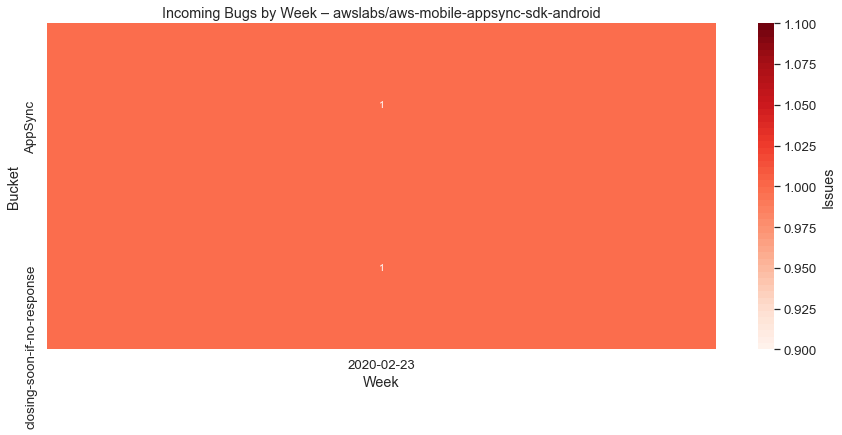

In [6]:
# Incoming Bugs by Week

from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)
#idx = pd.date_range(now - timedelta(weeks=12), now, freq='W')   

sns.set(font_scale=1.2)

%matplotlib inline

for repo_name, df in repos.items():
    plt.subplots(figsize=(15, 6))
        
    df = df.loc[df.created_at > now - timedelta(weeks=8)] 
    df = df.loc[np.array(list(map(len, df.labels.values))) > 0]
    df = df.labels.apply(pd.Series).merge(df, left_index = True, right_index = True)
    df = df.drop(["labels"], axis = 1)
    df = df.melt(id_vars = ['id', 'title', 'bucket', 'created_at', 'closed_at', 'score'], value_name = 'label')
    df = df.dropna(subset=['label'])
    df = df.loc[df.label.apply(lambda l: l not in issue_buckets.keys())]
    df = df.loc[df.bucket == 'Bug']
    df = df.pivot(index='created_at', columns='label', values='created_at')
    #df = pd.concat([df, pd.DataFrame(index=[date for date in idx])])    
    df = df.resample('W', label='left').count().transpose()

    dates = df.columns.strftime('%Y-%m-%d').sort_values().unique()
    ax = sns.heatmap(df, xticklabels=dates, cmap=sns.color_palette("Reds", 50), fmt='d', annot=True,
                     cbar_kws={'label': 'Issues'})
    ax.set(xlabel='Week', ylabel='Bucket', title=f'Incoming Bugs by Week – {repo_name}')

    plt.show()

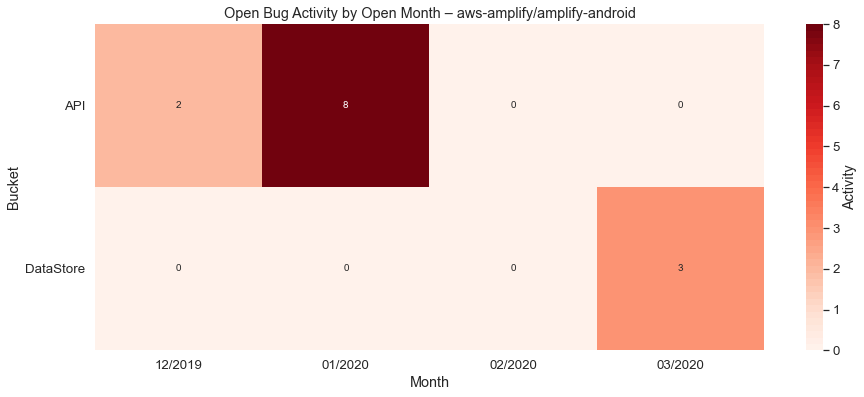

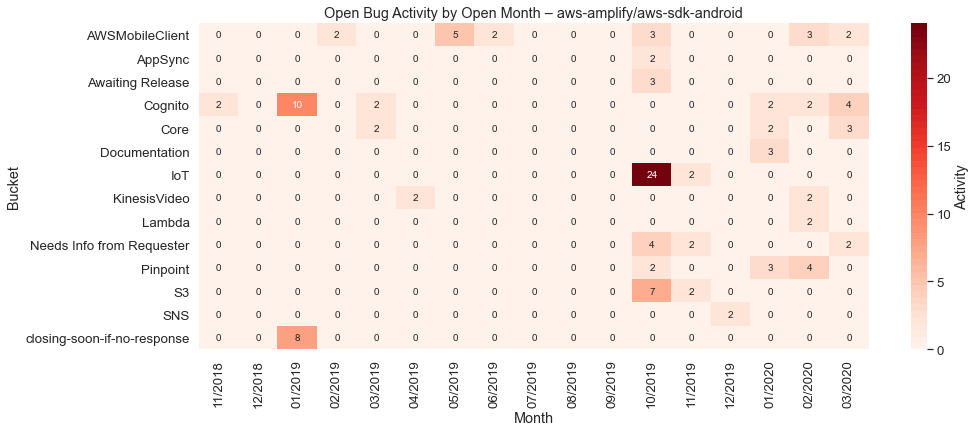

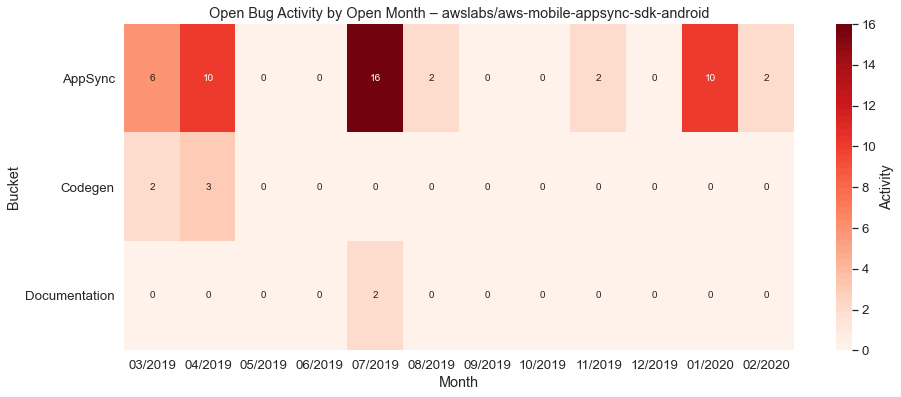

In [7]:
# Open Bug Activity by Open Week

from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)

sns.set(font_scale=1.2)

%matplotlib inline

for repo_name, df in repos.items():
    plt.subplots(figsize=(15, 6))
    
    df = df[~(df.closed_at > '1970-01-01')]
    df = df.loc[df.bucket == 'Bug']
    df = df.loc[np.array(list(map(len, df.labels.values))) > 0]
    df = df.labels.apply(pd.Series).merge(df, left_index = True, right_index = True)
    df = df.drop(["labels"], axis = 1)
    df = df.melt(id_vars = ['id', 'title', 'bucket', 'created_at', 'closed_at', 'score'], value_name = 'label')
    df = df.dropna(subset=['label'])
    df = df.loc[df.label.apply(lambda l: l not in issue_buckets.keys())]
    df = df.pivot(index='created_at', columns='label', values='score')
    df = df.resample('M', label='right').sum().transpose()

    dates = df.columns.strftime('%m/%Y')
    ax = sns.heatmap(df, xticklabels=dates, cmap=sns.color_palette("Reds", 50), annot=True,
                     cbar_kws={'label': 'Activity'})
    ax.set(xlabel='Month', ylabel='Bucket', title=f'Open Bug Activity by Open Month – {repo_name}')

    plt.yticks(rotation=0)
    plt.show()

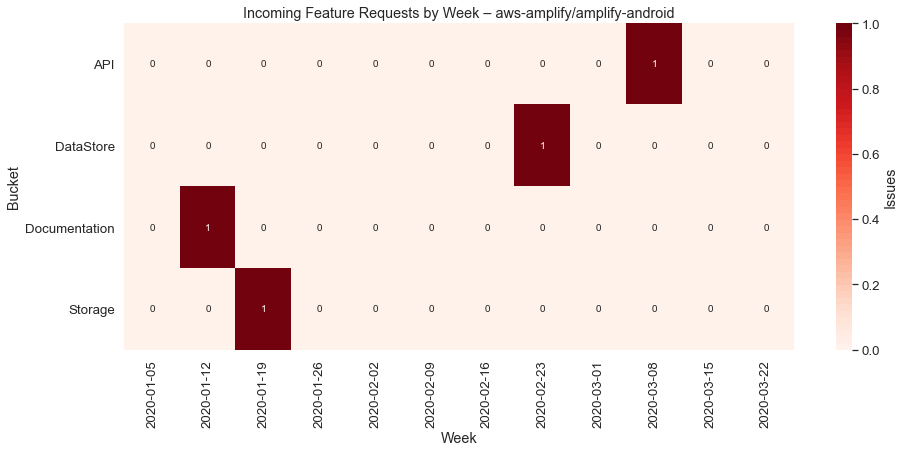

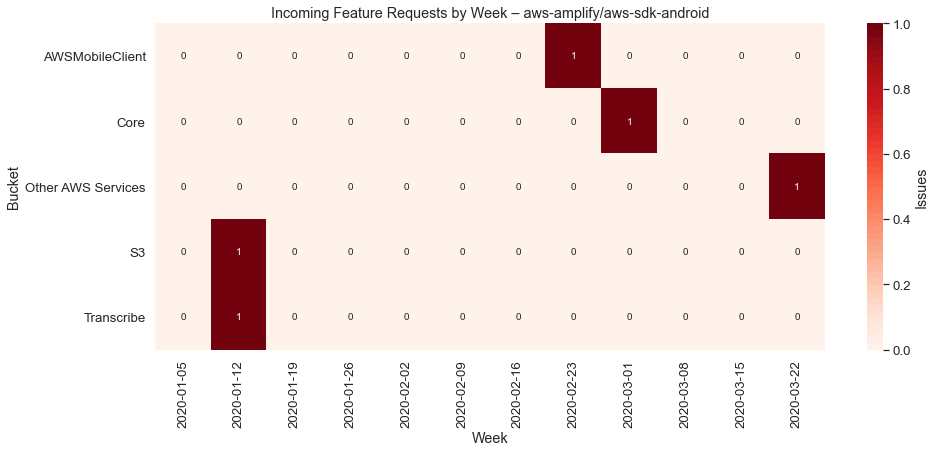

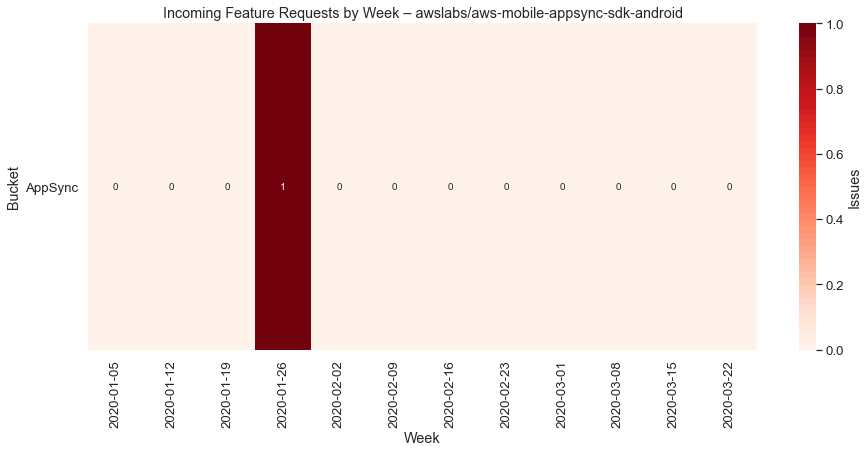

In [8]:
# Incoming Feature Requests by Week

from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)
idx = pd.date_range(now - timedelta(weeks=12), now, freq='W')   

sns.set(font_scale=1.2)

%matplotlib inline

for repo_name, df in repos.items():
    plt.subplots(figsize=(15, 6))
    
    df = df.loc[df.created_at > now - timedelta(weeks=12)] 
    df = df.loc[np.array(list(map(len, df.labels.values))) > 0]
    df = df.labels.apply(pd.Series).merge(df, left_index = True, right_index = True)
    df = df.drop(["labels"], axis = 1)
    df = df.melt(id_vars = ['id', 'title', 'bucket', 'created_at', 'closed_at', 'score'], value_name = 'label')
    df = df.dropna(subset=['label'])
    df = df.loc[df.label.apply(lambda l: l not in issue_buckets.keys())]
    df = df.loc[df.bucket == 'Feature Request']
    df = df.pivot(index='created_at', columns='label', values='created_at')
    df = pd.concat([df, pd.DataFrame(index=[date for date in idx])])    
    df = df.resample('W', label='left').count().transpose()
    
    dates = df.columns.strftime('%Y-%m-%d').sort_values().unique()
    ax = sns.heatmap(df, xticklabels=dates, cmap=sns.color_palette("Reds", 50), fmt='d', annot=True,
                     cbar_kws={'label': 'Issues'})
    ax.set(xlabel='Week', ylabel='Bucket', title=f'Incoming Feature Requests by Week – {repo_name}')

    plt.yticks(rotation=0)
    plt.show()

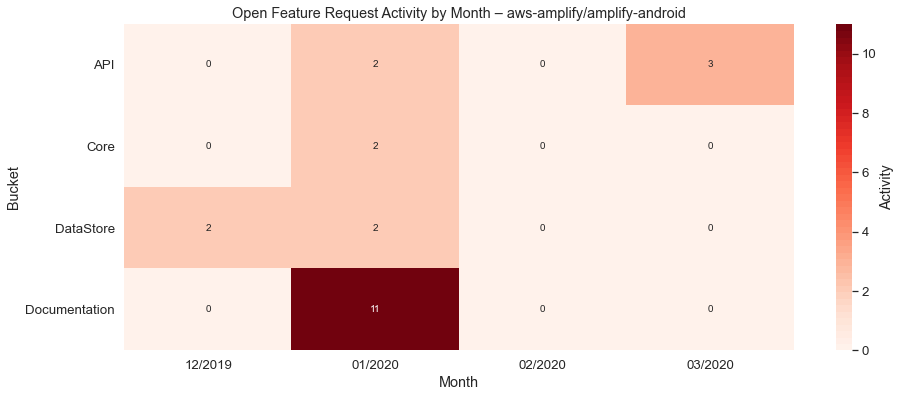

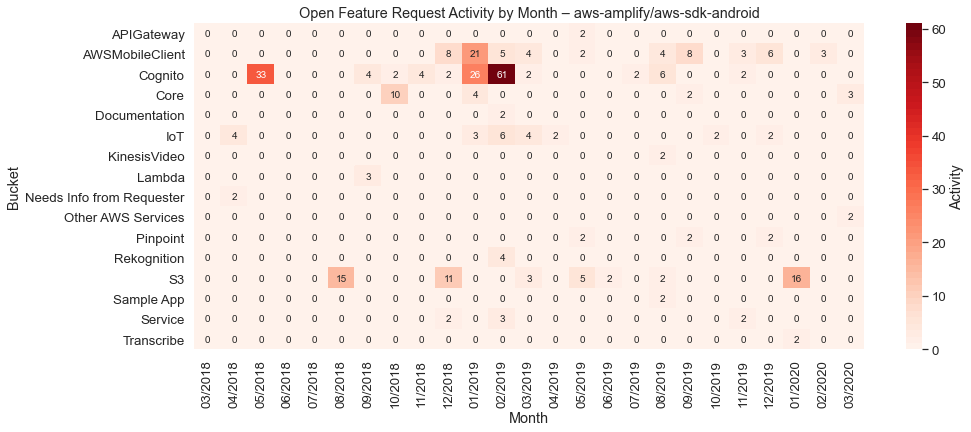

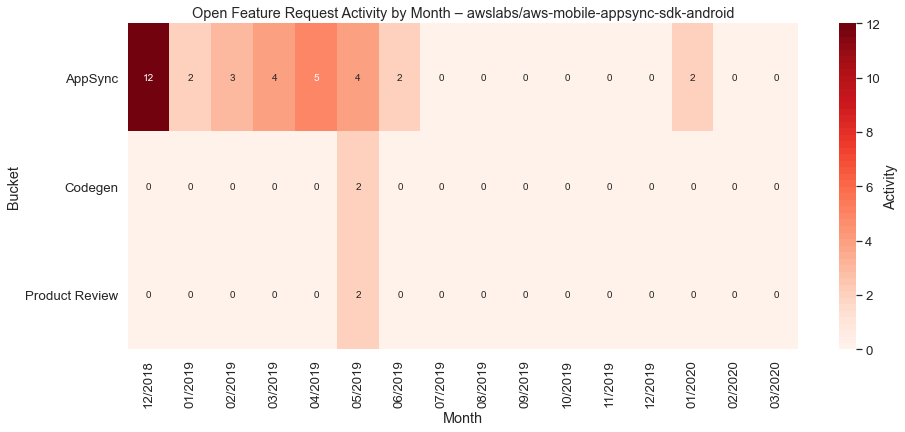

In [9]:
# Incoming Feature Request Activity by Open Week

from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)

sns.set(font_scale=1.2)

%matplotlib inline

for repo_name, df in repos.items():
    plt.subplots(figsize=(15, 6))

    df = df[~(df.closed_at > '1970-01-01')]
    
    weeks = (pd.to_datetime(now) - pd.to_datetime(df.created_at.min())) / np.timedelta64(1, 'W')
    idx = pd.date_range(now - timedelta(weeks=weeks), now, freq='W')

    df = df.loc[df.created_at > now - timedelta(weeks=weeks)] 
    df = df.loc[np.array(list(map(len, df.labels.values))) > 0]
    df = df.labels.apply(pd.Series).merge(df, left_index = True, right_index = True)
    df = df.drop(["labels"], axis = 1)
    df = df.melt(id_vars = ['id', 'title', 'bucket', 'created_at', 'closed_at', 'score'], value_name = 'label')
    df = df.dropna(subset=['label'])
    df = df.loc[df.label.apply(lambda l: l not in issue_buckets.keys())]
    df = df.loc[df.bucket == 'Feature Request']
    df = df.pivot(index='created_at', columns='label', values='score')
    df = pd.concat([df, pd.DataFrame(index=[date for date in idx])])    
    df = df.resample('M', label='right').sum().transpose()
    
    dates = df.columns.strftime('%m/%Y')
    ax = sns.heatmap(df, xticklabels=dates, cmap=sns.color_palette("Reds", 50), annot=True,
                     cbar_kws={'label': 'Activity'})
    ax.set(xlabel='Month', ylabel='Bucket', title=f'Open Feature Request Activity by Month – {repo_name}')
    plt.yticks(rotation=0)

    plt.show()

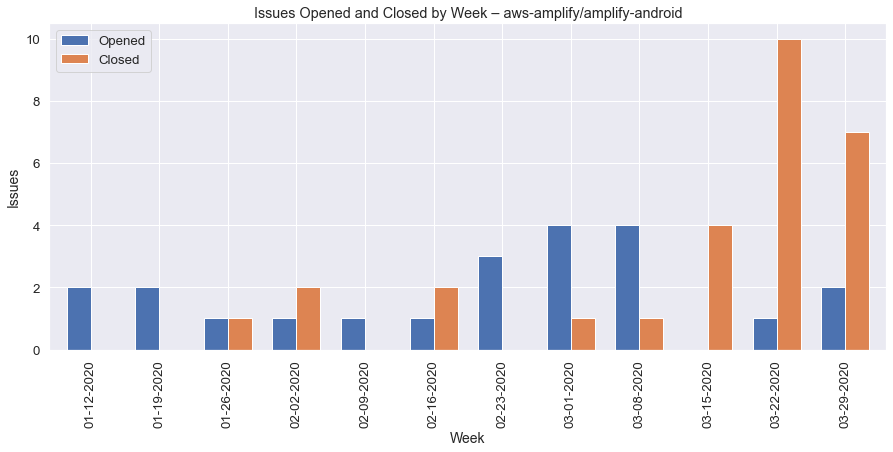

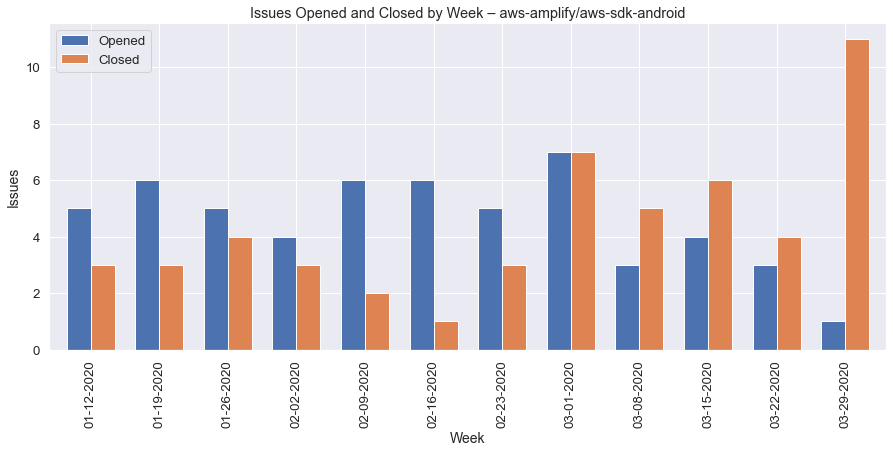

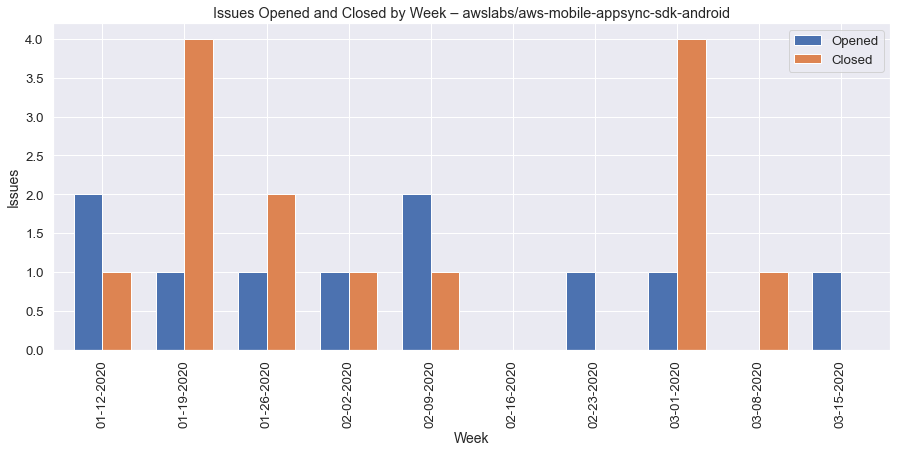

In [10]:
# Issues Opened and Closed by Week

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)

%matplotlib inline

for repo_name, df in repos.items():
    opened = df.loc[(df.created_at > now - timedelta(weeks=12))] 
    closed = df.loc[(df.closed_at > now - timedelta(weeks=12))] 
    
    opened = opened.set_index('created_at')
    opened = opened.id.resample('W', label='left').count().transpose().to_frame('count')
    closed = closed.dropna().set_index('closed_at').sort_values(by='closed_at')
    closed = closed.id.resample('W', label='left').count().transpose().to_frame('count')

    both = opened.join(closed, how='outer', lsuffix='_opened', rsuffix='_closed')
    both.index = both.index.rename('date')
    both = both.rename(columns={'count_opened': 'Opened', 'count_closed': 'Closed'})
    ax = both[['Opened','Closed']].plot(kind='bar', width=0.7, figsize=(15, 6), legend=True)

    ax.set_xlabel('Week', fontsize=14)
    ax.set_ylabel('Issues', fontsize=14)
    ax.set_xticklabels(both.index.strftime('%m-%d-%Y'))
    ax.set(title=f'Issues Opened and Closed by Week – {repo_name}')
    
    plt.show()

In [11]:
# Top Open Bugs by Activity

display(HTML(f'<h1>Top Open Bugs by Activity</h1>'))

for repo_name, df in repos.items():
    df = df.loc[df.bucket == 'Bug']
    df = df[~(df.closed_at > '1970-01-01')]
    df = df.sort_values(axis=0, by=['score'], ascending=False)

    display(HTML(f'<h2>{repo_name}</h2>'))
    display(df[['id', 'title', 'created_at', 'labels', 'score']].head(10))

,id,title,created_at,labels,score
29,216,GsonVariablesSerializer should support ISO 860...,2020-01-02 22:13:34+00:00,"[API, Bug]",4
44,293,DataStore SyncEngine to remain active even whi...,2020-03-03 20:09:48+00:00,"[Bug, DataStore]",3
18,186,[API] Subscribe fails if model has owner autho...,2019-12-10 16:49:38+00:00,"[API, Bug]",2
32,221,[API] Gson serializer does not handle timezone...,2020-01-07 01:18:29+00:00,"[API, Bug]",2
36,241,[API] The request signature we calculated does...,2020-01-20 13:43:49+00:00,"[API, Bug]",2


,id,title,created_at,labels,score
801,1259,AWSIotMqttManager NoClassDefFoundError with An...,2019-10-16 19:36:15+00:00,"[Bug, IoT]",20
567,679,Refresh token expired earlier than it should o...,2019-01-29 15:32:35+00:00,"[Bug, Cognito, closing-soon-if-no-response]",8
680,956,Sign in issue in AmazonKinesisVideoDemoApp,2019-05-13 21:40:47+00:00,"[AWSMobileClient, Bug]",5
854,1428,Incomplete documentation on Push Notifications,2020-01-10 11:06:13+00:00,"[Bug, Documentation, Pinpoint]",3
896,1507,Logged out after changing permission,2020-03-06 09:29:30+00:00,"[Bug, Core]",3
887,1495,UserID encryption not working,2020-02-29 19:51:26+00:00,"[AWSMobileClient, Bug]",3
803,1264,NullPointerException Attempt to invoke virtual...,2019-10-21 12:43:01+00:00,"[AWSMobileClient, Bug]",3
795,1236,S3 upload MD5 not automatically populated,2019-10-04 19:10:20+00:00,"[Awaiting Release, Bug, S3]",3
491,565,com.amazonaws.mobile.auth.ui.SignInUI - Keyboa...,2018-11-05 22:38:44+00:00,"[Bug, Cognito]",2
867,1460,KeyProvider23 keyStore.containsAlias(keyAlias),2020-01-30 14:52:15+00:00,"[Bug, Cognito, Core]",2


,id,title,created_at,labels,score
146,246,"Subscription initialization throws ""Invalid me...",2020-01-15 15:23:59+00:00,"[AppSync, Bug]",10
122,206,Disabling cache not working in Appsync / appollo,2019-07-18 21:06:12+00:00,"[AppSync, Bug]",6
123,207,Delta sync base query always runs again after ...,2019-07-23 06:08:10+00:00,"[AppSync, Bug]",4
92,145,[Performance] Apollo NormalizedCache performs ...,2019-04-08 10:57:32+00:00,"[AppSync, Bug]",3
104,163,Multidimensional array support,2019-04-29 12:43:50+00:00,"[AppSync, Bug, Codegen]",3
77,126,How to use getStore().write() when using jobco...,2019-03-05 13:58:54+00:00,"[AppSync, Bug]",2
78,127,Apollo mapping not working with Appsync Gradle...,2019-03-07 11:58:12+00:00,"[AppSync, Bug, Codegen]",2
86,136,IOException/SocketTimeoutException not propaga...,2019-03-26 18:42:58+00:00,"[AppSync, Bug]",2
93,147,Fatal Exception: android.database.sqlite.SQLit...,2019-04-11 11:06:09+00:00,"[AppSync, Bug]",2
97,153,How to handle java.lang.IllegalStateException ...,2019-04-19 05:54:50+00:00,"[AppSync, Bug]",2


In [12]:
# Top Open Feature Requests by Activity

display(HTML(f'<h1>Top Open Feature Requests by Activity</h1>'))

for repo_name, df in repos.items():
    df = df.loc[df.bucket == 'Feature Request']
    df = df[~(df.closed_at > '1970-01-01')]
    df = df.sort_values(axis=0, by=['score'], ascending=False)
    
    display(HTML(f'<h2>{repo_name}</h2>'))
    display(df[['id', 'title', 'created_at', 'labels', 'score']].head(10))

,id,title,created_at,labels,score
34,237,Add documentation for Kotlin,2020-01-14 06:22:51+00:00,"[Documentation, Feature Request]",11
50,303,Using Custom GraphQL Endpoint,2020-03-13 08:49:34+00:00,"[API, Feature Request]",3
20,195,When we will have unity SDK ?,2019-12-12 05:21:55+00:00,"[DataStore, Feature Request]",2
23,210,[API] GraphQL - Support for different Id field...,2020-01-02 17:12:42+00:00,"[API, Feature Request]",2
28,215,Amplify Initialization and Teardown,2020-01-02 22:04:09+00:00,"[Core, Feature Request]",2
31,220,[StorageEngine] Support storing lists and quer...,2020-01-06 23:21:05+00:00,"[DataStore, Feature Request]",2


,id,title,created_at,labels,score
572,684,Custom scopes in access token programmatically,2019-02-02 19:28:41+00:00,"[Cognito, Feature Request]",54
412,471,AWS Auth compatibility for API 22 and lower,2018-05-29 23:06:45+00:00,"[Cognito, Feature Request]",33
539,634,RFC - Auth workflows: improvements and additions,2019-01-04 00:51:33+00:00,"[AWSMobileClient, Cognito, Feature Request]",19
859,1436,TransferUtility upload - Support InputStream a...,2020-01-17 00:06:38+00:00,"[Feature Request, S3]",16
442,505,Upload multiple files using TransferUtility,2018-08-04 17:50:33+00:00,"[Feature Request, S3]",15
476,547,Add Secrets Manager to Android and iOS SDKs,2018-10-16 19:30:45+00:00,"[Core, Feature Request]",10
376,429,How to include custom authorization headers wh...,2018-03-23 14:25:44+00:00,"[Feature Request, IoT]",7
525,616,Adapt S3 TransferUtility for unstable network ...,2018-12-13 23:39:49+00:00,"[Feature Request, S3]",7
778,1204,Please provide refreshSession() method in AWSM...,2019-09-18 08:42:11+00:00,"[AWSMobileClient, Feature Request]",6
753,1136,Migrate users with a Lambda Trigger,2019-08-19 13:35:34+00:00,"[Cognito, Feature Request]",6


,id,title,created_at,labels,score
41,74,RXJava support,2018-12-03 07:30:45+00:00,"[AppSync, Feature Request]",8
99,155,Use Android apollo-client as a dependency inst...,2019-04-23 10:19:40+00:00,"[AppSync, Feature Request]",5
38,70,How can I know the time when a subscription ha...,2018-11-28 10:53:46+00:00,"[AppSync, Feature Request]",3
68,113,Including Mutation Payload in PersistentMutati...,2019-02-05 14:15:58+00:00,"[AppSync, Feature Request]",3
44,77,Mapping AWS built-in scalar types,2018-12-05 00:54:39+00:00,"[AppSync, Feature Request]",2
46,79,Implement callback to specify a custom retry p...,2018-12-05 20:38:19+00:00,"[AppSync, Feature Request]",2
52,94,Subscription retry even when the first request...,2019-01-07 14:56:05+00:00,"[AppSync, Feature Request]",2
83,133,Useless log outputs shows forever,2019-03-20 07:05:33+00:00,"[AppSync, Feature Request]",2
85,135,Support `null` literal for optional fields,2019-03-20 20:59:00+00:00,"[AppSync, Feature Request]",2
105,176,Make generated code's field name different the...,2019-05-08 07:36:55+00:00,"[AppSync, Codegen, Feature Request]",2


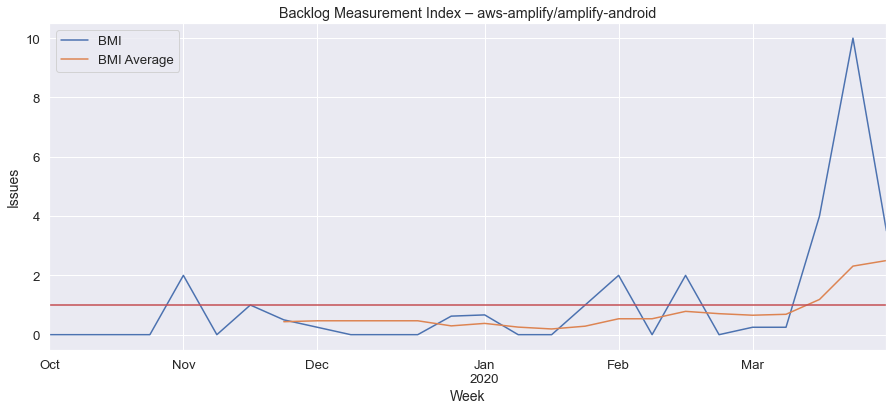

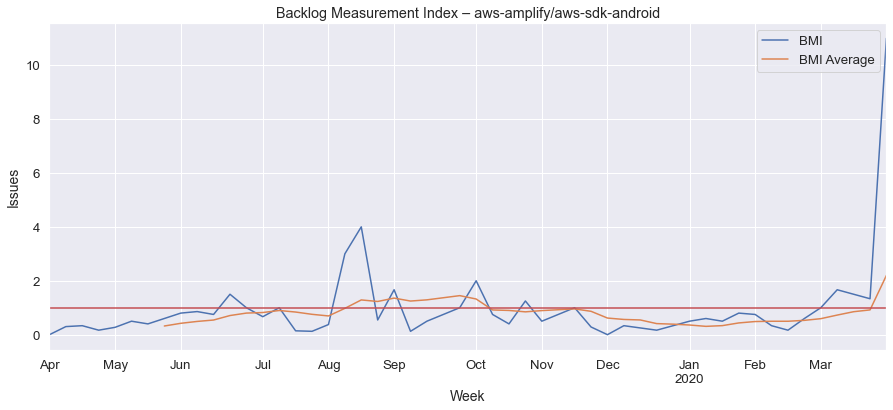

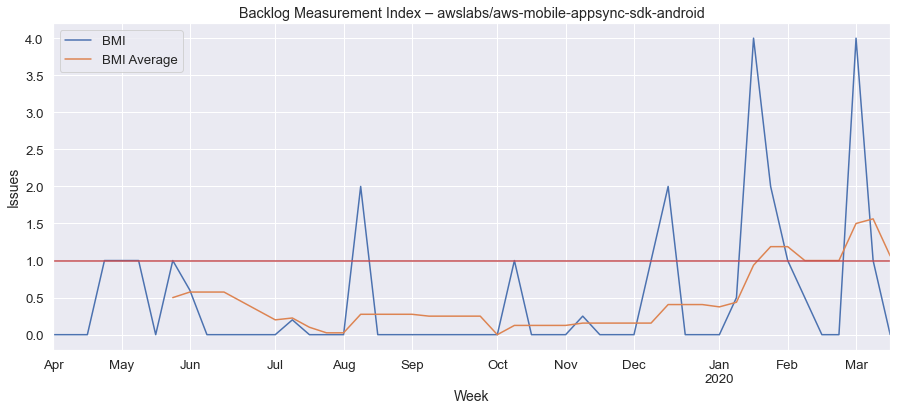

In [13]:
# Backlog Management Index

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)

%matplotlib inline

for repo_name, df in repos.items(): 
    df = df.loc[df.created_at > now - timedelta(weeks=52)] 

    opened = df.set_index('created_at')
    opened = opened.id.resample('W', label='left').count().transpose().to_frame('count')
    closed = df.dropna().set_index('closed_at').sort_values(by='closed_at')
    closed = closed.id.resample('W', label='left').count().transpose().to_frame('count')

    both = opened.join(closed, how='outer', lsuffix='_opened', rsuffix='_closed')
    both.index = both.index.rename('date')
    both = both.rename(columns={'count_opened': 'Opened', 'count_closed': 'Closed'})

    both['Closed'] = both['Closed'].fillna(0)
    both['Opened'] = both['Opened'].fillna(0)
    both['BMI'] = both['Closed'] / both['Opened']
    both['BMI'] = both['BMI'].replace([np.inf, -np.inf], np.nan)
    both['BMI'] = both['BMI'].fillna(both['Closed'])

    both['BMI Average'] = both['BMI'].rolling(window=8).mean()

    ax = both[['BMI', 'BMI Average']].plot(kind='line', figsize=(15, 6), legend=True)
    ax.set_xlabel('Week', fontsize=14)
    ax.set_ylabel('Issues', fontsize=14)
    
    ax.set(title=f'Backlog Measurement Index – {repo_name}')
    
    plt.axhline(y=1.0, color='r', linestyle='-')
    plt.show()